# Naive Representive Point (mit PCA)
- PCA des Cluster-Paares:
    - PC 1 von einer Schiene zur anderen
    - PC 2 entlang der Schiene
    - PC 3 senkrecht darauf nach oben oder unten
- Naiver Repräsentativer Punkt mit 
    - x,y von Clustercentroid
    - z als z.B. 95. Perzentile des z. Werts des Clusters in der PCA des Clusterpaares
    - Vorteil: Steigung wirkt sich nicht aus (würde sonst das jeweils obere Ende nehmen)
- Auch gut zum Plotten
- Die Punkte können eine 1 cm breit streuende Wolke sein (unabhängig von PC2 = entlang der Schiene)
- Wo genau das Clustercentroid in diesen PCs landet, hängt stark von der Verteilung der Punkte ab:
    - Anzahl Punkte im jeweiligen Cluster
    - Verteilung der Punkte innerhalb der Cluster, insbes. wenn überwiegend Punkte auf der Seite
- Nahe Trajektorie: 
    - Punkte z überwiegend 0-2 cm über Clusterzentrum
    - Breite entspricht etwa der Schienenkopfbreite
    - ganz wenige Punkte an den Seiten und nicht weit herunter
- Entfernt von Trajektorie:
    - Verteilung in z und quer dazu viel größer
    - Korrekte Schienenmitte meist etwas weniger als 2 cm gegenüber Centroid verschoben
- Manchmal sieht es aus, als ob es zwei um cm diagonal versetzte Schienen da sind (Versatz der Scanlinien? Multipath?) "Viele Gleise"
- Möglich, dass eine Schiene vor allem von oben und die andere vor allem von Seite. Da die jeweilige Variation in z sehr unterschiedlich ist, ist in den PC die jeweilige Schienenoberkante auf einem anderen Niveau. Dadurch ist alles leicht geneigt und die 95. Perzentile ist nicht die richtige Stelle. ("Viele Gleise") Passiert an Weichen am einbiegenden Gleis.
- Farbverlauf: Ablenkung der PC2 (entlang Schiene) 
    - Weichenteile, Ausreißer
    - Lücke in einem Cluster oder Abschnitt mit weniger Punkten
- Idee:
    - Anderer Versuch mit anderer Projektion
    - Fallunterschiedungen:
        - Wenn keine Punkte > 2 cm über Centroid: Die Punkte sind vor allem auf Schienenoberseite. 
        - Ansonsten die Punkte in den Quadranten um das Centroid zählen. Fast immer gibt das eine Diagonale, aus der ablesbar ist, welche Seite wir haben
        - Bei ganz weit abseits liegenden Schienen ist es nicht mehr eindeutig, braucht evtl. andere Strategie

Fazit:
- PCA mit Paar nicht ideal, weil zu leicht abgelenkt (Lücke, Ausreißer)

In [1]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt


from interessant import * # Bei Änderungen Kernel neu starten

ogr.UseExceptions()

In [2]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
tmpdir = "/media/riannek/minimax/gleis/temp_fertig"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A (in run24 Achszähler): 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43

key = list(interessant.keys())[33] 

filename = interessant[key]
filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, filename)):
    raise FileNotFoundError(filename)

Viele Gleise 4474750_5332150.ply


In [4]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435

In [ ]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
# subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

<Popen: returncode: None args: ['pyvistaviewer', '/media/riannek/minimax/gle...>

## Datei incl. margin aus Nachbarkacheln

In [6]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [7]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [8]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4474725_5332175.ply', '4474750_5332175.ply', '4474750_5332125.ply', '4474725_5332150.ply', '4474775_5332125.ply', '4474775_5332150.ply', '4474750_5332150.ply', '4474725_5332125.ply', '4474775_5332175.ply']


In [9]:
bbox # MinX, MaxX, MinY, MaxY

(4474750.0, 4474775.0, 5332150.0, 5332175.0)

In [10]:
del gpkg

In [11]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4474748.0, 4474777.0], [5332148.0, 5332177.0])'

In [12]:
readers = [pdal.Reader(os.path.join(tmpdir, tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

Reading /media/riannek/minimax/gleis/run24-2024-08-13/4474750_5332150.copc.laz


(296313,)

## Seed Points

In [13]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(247472,)

In [14]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4474750.0, 4474775.0], [5332150.0, 5332175.0])'

In [15]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

526

## KD Tree

In [16]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [17]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [18]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

## Funktionen

In [19]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

def linearity(eigenvals):
    """Calculate the linearity of a point cloud"""
    return (eigenvals[0] - eigenvals[1]) / eigenvals[0]

def verticality(eigenvects):
    """Calculate the verticality of a point cloud
    
    1 minus z of the third eigenvector
    """
    return 1 - eigenvects.T[2][2]

In [20]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [21]:
def plot_cluster_line(cluster, eigenvects, stretch=0.2):
    start = cluster.mean(axis=0)
    vector = eigenvects.T[0] * stretch
    end = start + vector
    line = pv.Line(start, end)

    return line

In [22]:
def plot_first_eigenvec(point, eigenvects, color=[1, 0, 0], stretch=1):
    """Plot a vector as a line"""
    vector = eigenvects.T[0] * stretch
    end = point + vector
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([point, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

In [23]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [24]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

## Iteration über Seed Points

In [25]:
with_lines = True

In [26]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.1, clustercenter[0] + 0.1
    y_min, y_max = clustercenter[1] - 0.1, clustercenter[1] + 0.1
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0


In [27]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)

    # if len(labels) == 0:
    #     return
    
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue
        

        yield cluster, clustercenter, eigenvals, eigenvects


def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [28]:
def naive_representive_point(cluster, eigenvects):
    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ eigenvects
    transformed_clustercenter_xy = transformed[:,:2].mean(axis=0)
    # transformed_max_z = transformed[:,2].max()
    transformed_max_z = np.percentile(transformed[:,2],95)
    transformed_representive = np.array([transformed_clustercenter_xy[0], transformed_clustercenter_xy[1], transformed_max_z])
    return transformed_representive @ eigenvects.T + center

In [66]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [30]:
def plot_cluster_pair(cluster, cluster_other, eigenvects, percentile=99, railhead_width = 0.067, centering="cluster"): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center

    transformed = cluster @ eigenvects
    transformed_other = cluster_other @ eigenvects
    print("center", center)
    print(center_cluster - center, center_other - center)
    print((center_cluster - center) @ eigenvects, (center_other - center) @ eigenvects)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ eigenvects
    center_other_in_pc = (center_other - center) @ eigenvects
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [31]:
def clusterhistograms(cluster, cluster_other):
    bin_max = 0
    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    counts,_,_ = ax[0,0].hist(cluster[:,0], bins=14, range=(-0.07, 0.07))
    bin_max = max(bin_max, counts.max())
    counts,_,_ = ax[0,1].hist(cluster_other[:,0], bins=14, range=(-0.07, 0.07))
    bin_max = max(bin_max, counts.max())
    counts,_,_ = ax[1,0].hist(cluster[:,2], bins=14, orientation="horizontal", range=(-0.08, 0.06))
    bin_max = max(bin_max, counts.max())
    counts,_,_ = ax[1,1].hist(cluster_other[:,2], bins=14, orientation="horizontal", range=(-0.08, 0.06))
    bin_max = max(bin_max, counts.max())

    ax[0,0].set_ylim(0, bin_max)
    ax[0,1].set_ylim(0, bin_max)
    ax[1,0].set_xlim(0, bin_max)
    ax[1,1].set_xlim(0, bin_max)

    for a in ax.flat:
        a.set_box_aspect(1)
        
    plt.show()

In [131]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, cluster_other

pair_gen = pair_generator()

In [130]:
for i in range(20):
    cluster, cluster_other = next(pair_gen)

StopIteration: 

Inverted eigenvectors
Points per Cluster 1065 1457
center [6.43865527 0.55596191 0.36658617]
[0.42847578 0.75888507 0.01220299] [-0.31319609 -0.55471009 -0.00891983]
[ 8.71577261e-01 -1.64688184e-04  2.64277734e-05] [-6.37082898e-01  1.20379489e-04 -1.93174870e-05]
Switched clusters


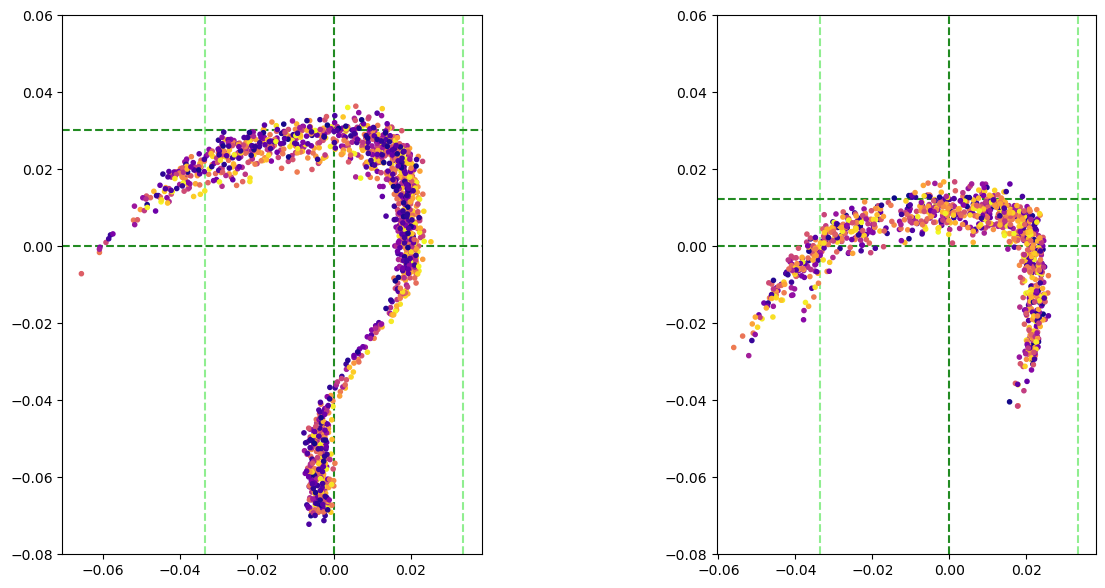

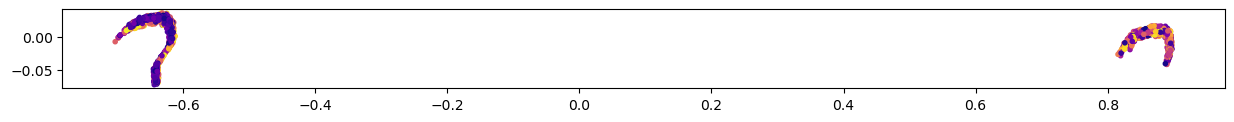

In [135]:
cluster, cluster_other = next(pair_gen)
clustercenter = cluster.mean(axis=0)
clustercenter_other = cluster_other.mean(axis=0)

pair = np.vstack((cluster, cluster_other))
eigenvals, eigenvects = pca(pair)


if eigenvects[2,2] < 0: # z of the third eigenvector
    print("Inverted eigenvectors")
    eigenvects *= -1
    
representive_a, representive_b = naive_representive_point(cluster, eigenvects), naive_representive_point(cluster_other, eigenvects)
central = get_central_point(representive_a, representive_b)


#o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])
print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair(cluster, cluster_other, eigenvects, percentile=95, railhead_width = 0.067, centering="cluster")
figb, axb = plot_cluster(pair, eigenvects);

In [ ]:
#figb.savefig("cluster_pair.png", bbox_inches="tight", dpi=300)

In [139]:
pcd_clusters = o3d.geometry.PointCloud()
pcd_clusters.points = o3d.utility.Vector3dVector(pair)
pcd_clusters.paint_uniform_color([0, 0, 1])

pcd_clustercenters = o3d.geometry.PointCloud()
pcd_clustercenters.points = o3d.utility.Vector3dVector([clustercenter, clustercenter_other])
pcd_clustercenters.paint_uniform_color([0, 1, 0])

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.7, 0.7, 0.7])

pcd_representive = o3d.geometry.PointCloud()
pcd_representive.points = o3d.utility.Vector3dVector([representive_a, representive_b, central])
pcd_representive.paint_uniform_color([1, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

#o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])
o3d.visualization.draw_geometries([pcd_all, pcd_clusters])

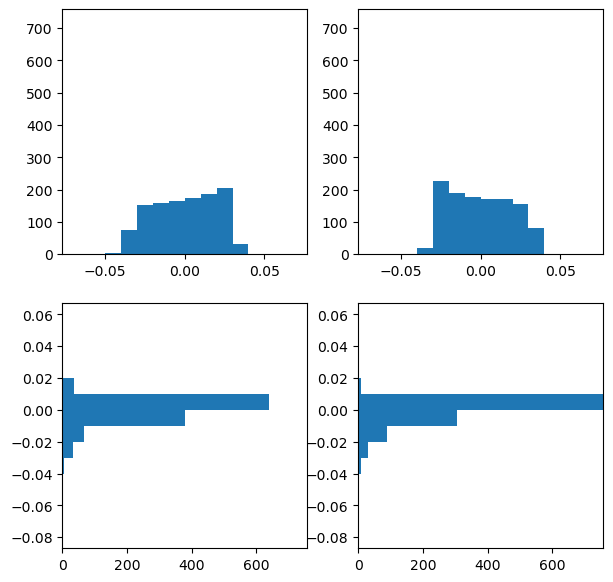

In [36]:
clusterhistograms(transformed, transformed_other)